# Transfer Learning on Bengali Sign Language

## Setup

In [2]:
# set the python env so that we can use the project utils
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K
from tqdm import tqdm

K.clear_session()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-05 19:12:48.181740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738775568.573272   20397 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738775568.698355   20397 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 19:12:49.373047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

Train and Test set are also found into two separate folders.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set


In [2]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("../../sign_datasets/bengali-sign-language-dataset/RESIZED_DATASET/1/20180624_235329.jpg")

print(f'Image dimentions: {img.size}')

Image dimentions: (224, 224)


In [3]:
train_dataset_path = "../../sign_datasets/bengali-sign-language-dataset/RESIZED_DATASET"
test_dataset_path = (
    "../../sign_datasets/bengali-sign-language-dataset/RESIZED_TESTING_DATA"
)

train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=64,
    validation_split=0.15,
    shuffle=True,
    seed=42,
    subset="both",
)

# The test dataset is under the test folder
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=64,
    shuffle=True,
)


def normalize_image(image, label):
    precomputed_mean = [0.6287722587585449, 0.6092960834503174, 0.5825445055961609]
    precomputed_std = [0.6499956250190735, 0.6389758586883545, 0.6195625066757202]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label


train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(
    f"Train size: {train_dataset.cardinality().numpy()}. Validation size will be: {val_dataset.cardinality().numpy()}"
)

# Set performance settings
# Prefetch one batch at a time
buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)


Found 11061 files belonging to 38 classes.
Using 9402 files for training.
Using 1659 files for validation.


I0000 00:00:1738433336.629977   26472 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2859 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 1520 files belonging to 38 classes.
Train size: 147. Validation size will be: 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9402514..0.24970913].


(64, 224, 224, 3)


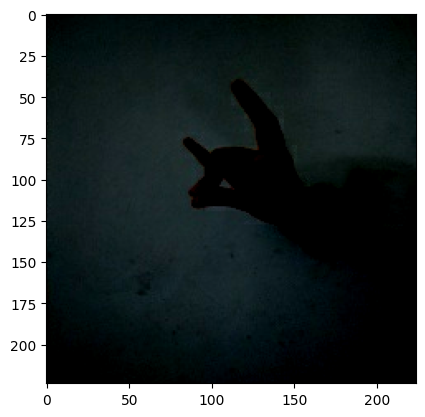

In [4]:
# Print a random image to make sure it's properly shown
images, labels = next(iter(train_dataset))

print(images.shape)

plt.imshow(images[0, :, :, :])
plt.show()

## Helper Methods

The following methods aim to make the code easier

In [5]:
from sklearn.metrics import confusion_matrix


def get_class_count(dataset):
    """Find out how many elements bellong to each class
    This method is used in plot_class_distribution to plot
    the distribution of the data
    
    Return:
        class_counts: A dictionary with the class name as a key
        and the total items as a value
    """
    class_counts = {}
    for images, labels in tqdm(dataset):
        for label in labels:
            # Here the label is a tensor with 1 element
            # We have to convert it to numpy
            label = label.numpy()
            # Count it
            class_counts[label] = class_counts.get(label, 0) + 1
    # Return the counts
    return class_counts

def plot_class_distribution(dataset, title: str):
    """Get how many elements belong to each class and plot them
    
    This method can help us see if there is an inbalance in the data
    """
    # Get the class counts
    class_counts = get_class_count(dataset)

    # greate an index for the dataframe
    index = list(range(len(class_counts)))
    # Create a dataframe
    df = pd.DataFrame(class_counts, index=index)
    
    # Set the figure size
    plt.figure(figsize=(12, 6))
    # Add the data
    ax = sns.barplot(df)
    # Set the title
    ax.set_title(title)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    # Adjust layout to make room for rotated labels
    plt.tight_layout()
    plt.show()

def plot_history(history):
    """Plot the history returned by the training
    """

    # Convert history to a DataFrame
    history_df = pd.DataFrame(history.history)

    # Create a single figure with two subplots
    fig, ax1 = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plotting training and validation loss
    sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax1[0])
    ax1[0].set_title('Model Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].legend(['Train', 'Validation'])
    
    # Plotting training and validation accuracy
    sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax1[1])
    ax1[1].set_title('Model Accuracy')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Accuracy')
    ax1[1].legend(['Train', 'Validation'])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 147/147 [00:15<00:00,  9.55it/s]


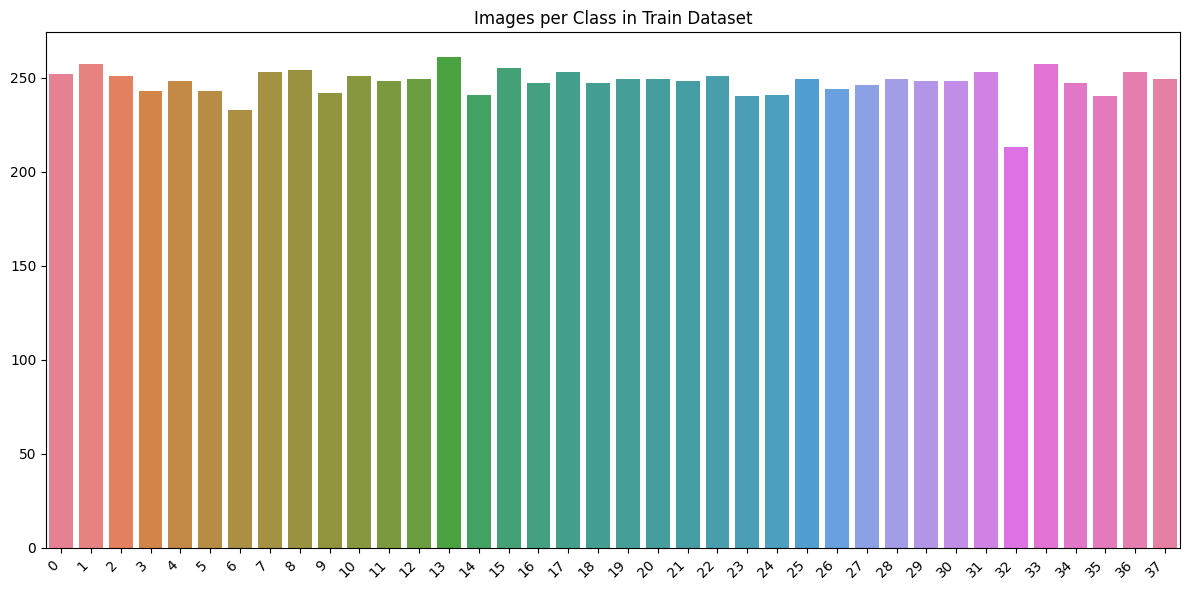

In [11]:
plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


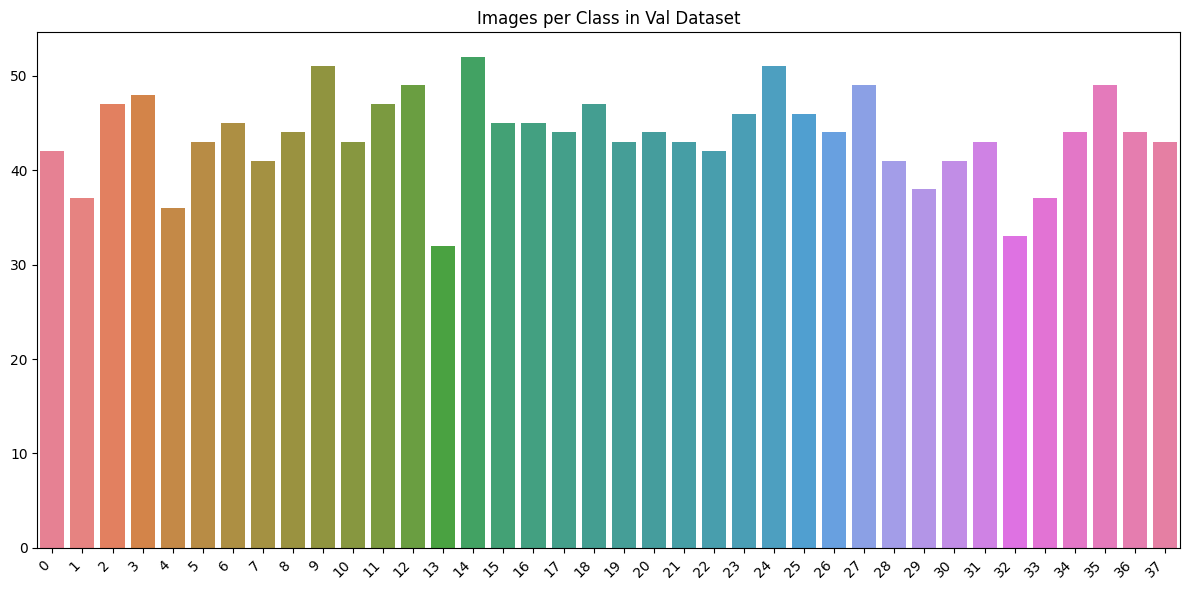

In [12]:
plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 24/24 [00:01<00:00, 12.48it/s]


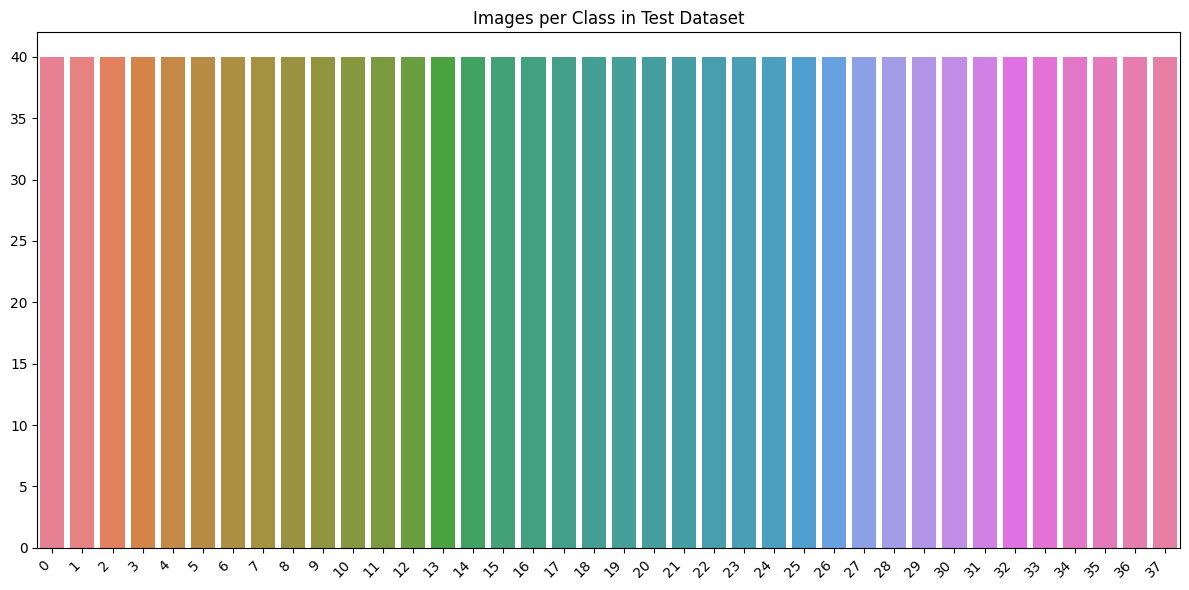

In [13]:
plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## Extract Class Names

In [4]:
def get_class_names(test_dataset, verbose: bool = False):
    class_names = set()

    for _, labels in tqdm(test_dataset, desc="Gathering Labels"):
        for label in labels:
            class_names.add(int(label))

    if verbose:
        print(f"Unique Dataset Labels: {class_names}")

    return class_names

In [5]:
class_names = get_class_names(test_dataset=test_dataset, verbose=True)

Gathering Labels: 100%|██████████| 380/380 [00:03<00:00, 104.06it/s]

Unique Dataset Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37}


## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (400, 400) to (224, 244)

We will try __different hidden sizes__ with __3 epochs__, using a __dropout__ of 0.3

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,366 (9.26 MB)

 Trainable params: 169,126 (660.65 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

None
Epoch 1/10


I0000 00:00:1738433364.384250   26528 service.cc:148] XLA service 0x7f5a04003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738433364.384364   26528 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-02-01 20:09:24.652505: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738433365.527404   26528 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/147 ━━━━━━━━━━━━━━━━━━━━ 49:44 20s/step - accuracy: 0.0938 - loss: 4.3227

I0000 00:00:1738433378.059817   26528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 73s 360ms/step - accuracy: 0.2758 - loss: 2.8198 - val_accuracy: 0.6769 - val_loss: 1.2918
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.6652 - loss: 1.2233 - val_accuracy: 0.7547 - val_loss: 0.9041
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.7455 - loss: 0.8890 - val_accuracy: 0.7800 - val_loss: 0.7643
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.7970 - loss: 0.7045 - val_accuracy: 0.7975 - val_loss: 0.6859
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - accuracy: 0.8334 - loss: 0.5739 - val_accuracy: 0.7993 - val_loss: 0.6557
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - accuracy: 0.8479 - loss: 0.5113 - val_accuracy: 0.7963 - val_loss: 0.6450
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.8680 - loss: 0.4408 - val_accuracy: 0.8023 - val_loss: 0.6104
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.8752 - loss: 0.3999 - val

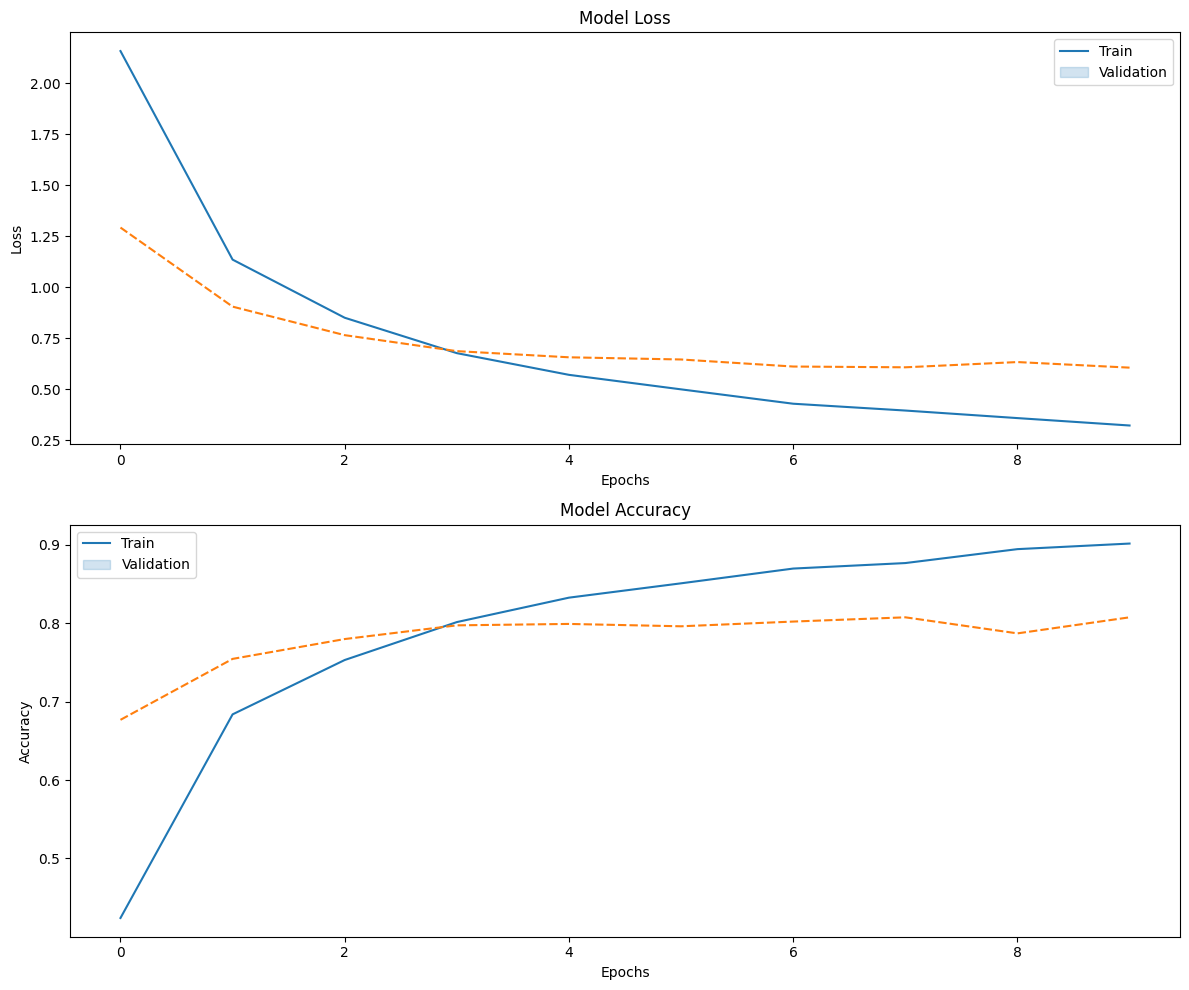

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,596,710 (9.91 MB)

 Trainable params: 338,214 (1.29 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

None
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - accuracy: 0.3439 - loss: 2.4531 - val_accuracy: 0.7040 - val_loss: 1.0863
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.7397 - loss: 0.9038 - val_accuracy: 0.7577 - val_loss: 0.8067
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - accuracy: 0.8138 - loss: 0.6395 - val_accuracy: 0.7975 - val_loss: 0.6771
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.8544 - loss: 0.4965 - val_accuracy: 0.8053 - val_loss: 0.6371
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.8781 - loss: 0.4071 - val_accuracy: 0.7945 - val_loss: 0.6588
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.9010 - loss: 0.3459 - val_accuracy: 0.8131 - val_loss: 0.6163
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.9157 - loss: 0.2833 - val_accuracy: 0.8113 - val_loss: 0.6177
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.9278 - lo

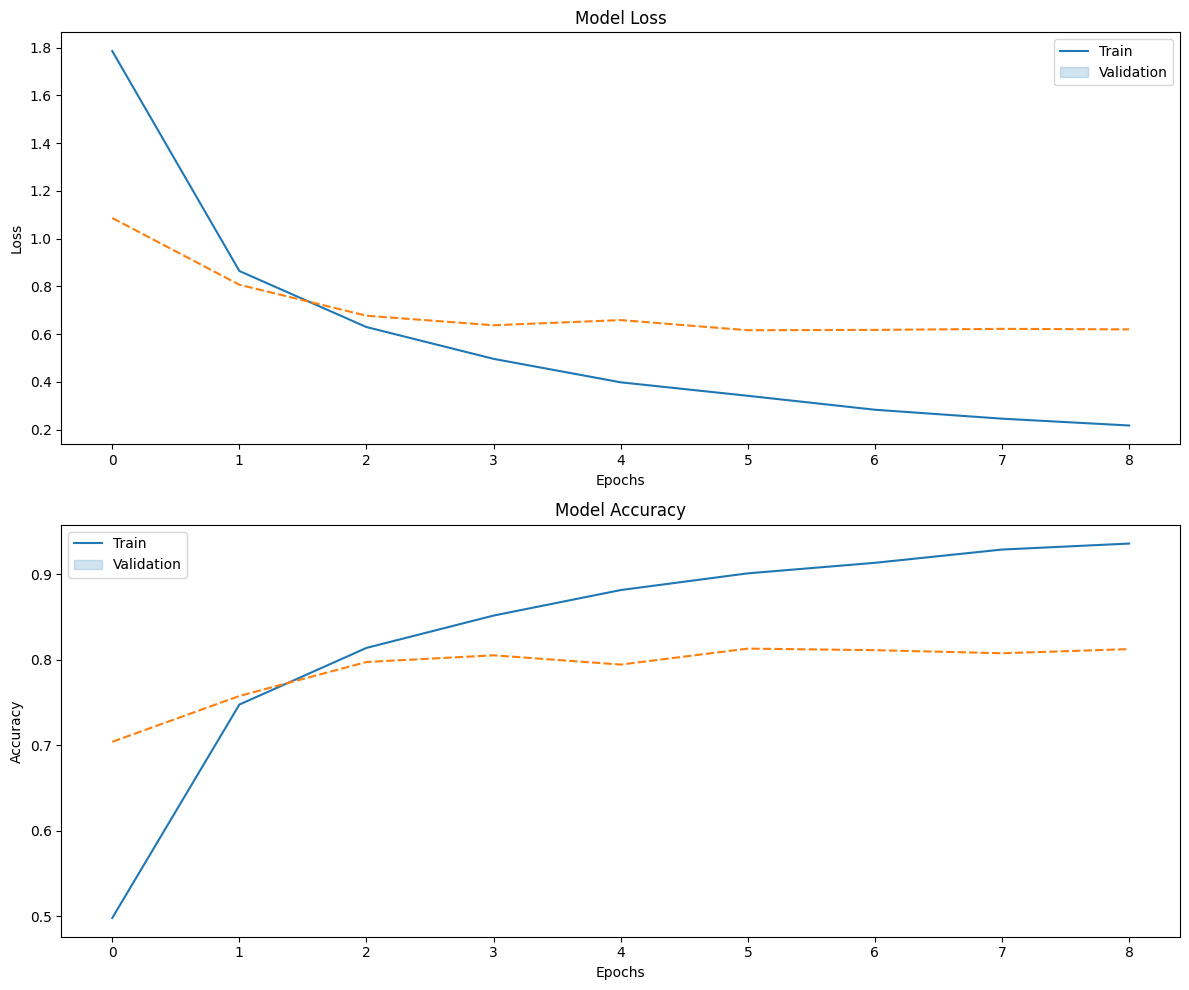

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,935,398 (11.20 MB)

 Trainable params: 676,390 (2.58 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

None
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 220ms/step - accuracy: 0.4183 - loss: 2.1511 - val_accuracy: 0.7408 - val_loss: 0.8906
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.7883 - loss: 0.7036 - val_accuracy: 0.7932 - val_loss: 0.6971
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.8496 - loss: 0.4950 - val_accuracy: 0.7969 - val_loss: 0.6338
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.8907 - loss: 0.3637 - val_accuracy: 0.7987 - val_loss: 0.6329
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.9205 - loss: 0.2817 - val_accuracy: 0.8041 - val_loss: 0.6126
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - accuracy: 0.9363 - loss: 0.2263 - val_accuracy: 0.8017 - val_loss: 0.6220
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 161ms/step - accuracy: 0.9490 - loss: 0.1823 - val_accuracy: 0.8071 - val_loss: 0.6275
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.9643 - lo

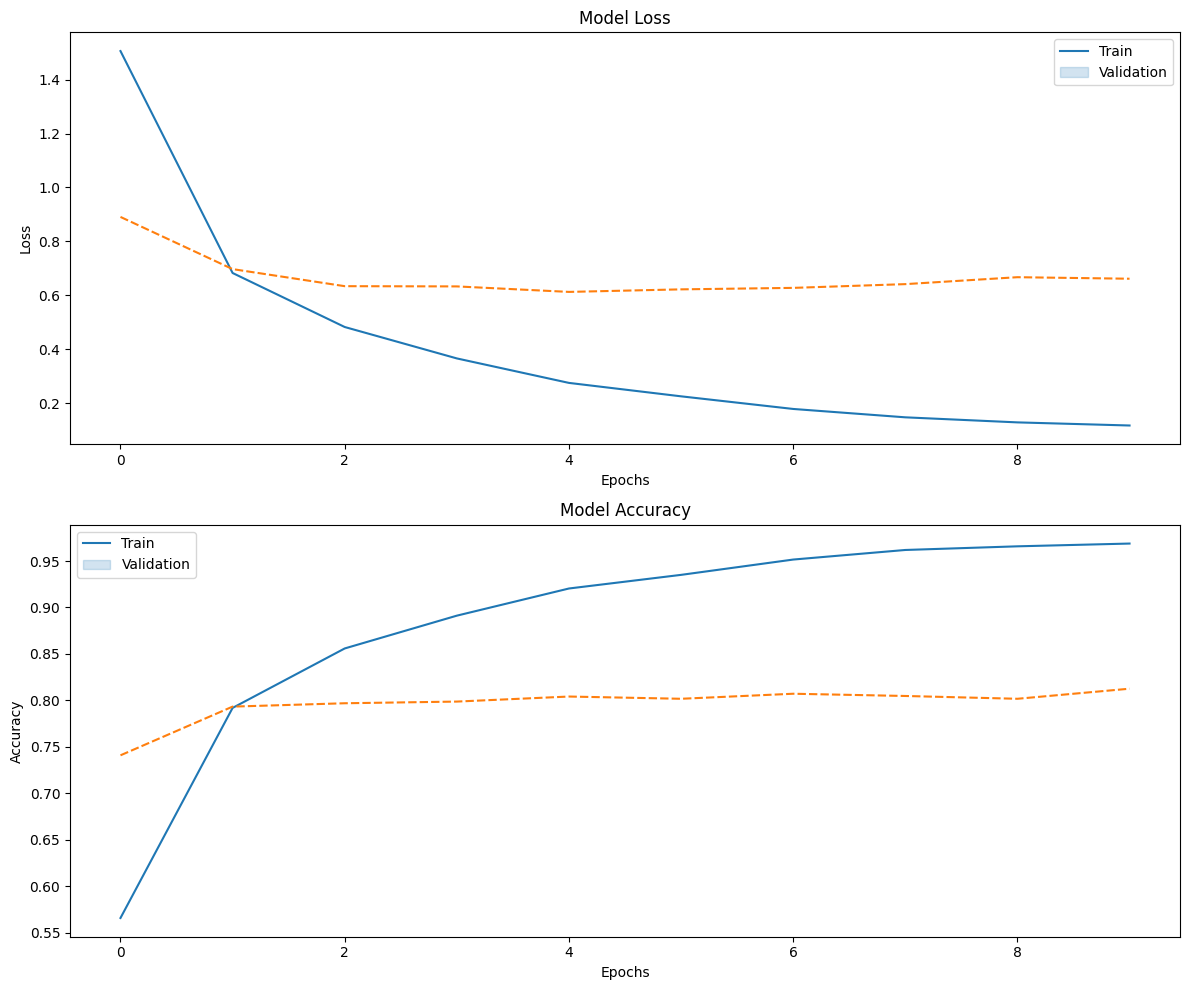

24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 580ms/step - accuracy: 0.8094 - loss: 0.6055
Test Loss: 0.5969637632369995
Test Accuracy: 0.8072368502616882


In [8]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    
    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)


# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

## Confusion Matrix

  0%|          | 0/24 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step


  4%|▍         | 1/24 [00:10<03:52, 10.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  8%|▊         | 2/24 [00:10<01:34,  4.30s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 12%|█▎        | 3/24 [00:10<00:51,  2.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 17%|█▋        | 4/24 [00:10<00:31,  1.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 21%|██        | 5/24 [00:11<00:20,  1.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 25%|██▌       | 6/24 [00:11<00:14,  1.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 29%|██▉       | 7/24 [00:11<00:10,  1.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 33%|███▎      | 8/24 [00:11<00:07,  2.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 38%|███▊      | 9/24 [00:11<00:06,  2.48it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 42%|████▏     | 10/24 [00:12<00:04,  2.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 46%|████▌     | 11/24 [00:12<00:04,  3.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 50%|█████     | 12/24 [00:12<00:03,  3.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 54%|█████▍    | 13/24 [00:12<00:02,  3.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 58%|█████▊    | 14/24 [00:13<00:03,  3.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 62%|██████▎   | 15/24 [00:13<00:02,  3.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 67%|██████▋   | 16/24 [00:13<00:02,  3.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 71%|███████   | 17/24 [00:13<00:01,  4.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 75%|███████▌  | 18/24 [00:14<00:01,  4.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 79%|███████▉  | 19/24 [00:14<00:01,  4.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 83%|████████▎ | 20/24 [00:14<00:00,  4.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 88%|████████▊ | 21/24 [00:14<00:00,  4.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 92%|█████████▏| 22/24 [00:14<00:00,  4.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 96%|█████████▌| 23/24 [00:15<00:00,  4.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step 


100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


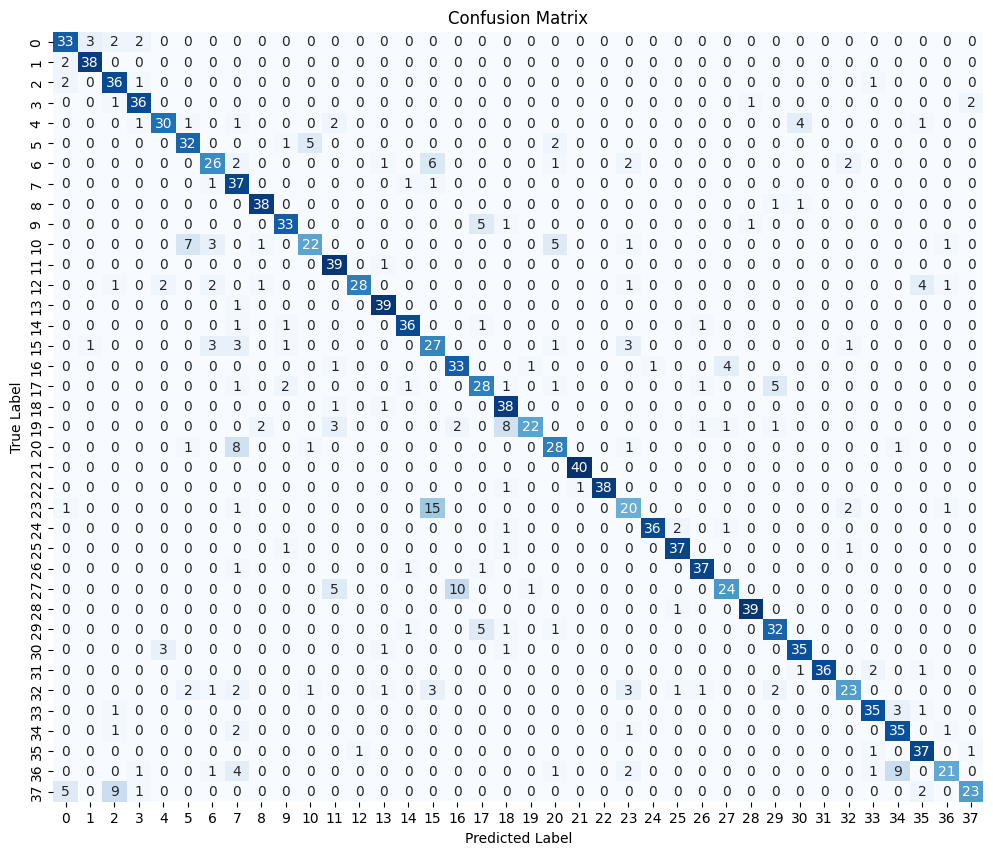

In [9]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)

## ConvNeXtBase Transfer Learning

Let's try to finetune `ConvNeXtBase` for our task.

`ConvNeXtBase` is trained on the `imagenet` dataset

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,703,078 (334.56 MB)

 Trainable params: 136,358 (532.65 KB)

 Non-trainable params: 87,566,720 (334.04 MB)

None
Epoch 1/10


E0000 00:00:1738434712.441573   26528 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


147/147 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.1960 - loss: 3.1610 - val_accuracy: 0.3369 - val_loss: 2.5998
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.5804 - loss: 1.5795 - val_accuracy: 0.5895 - val_loss: 1.6118
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.6932 - loss: 1.1273 - val_accuracy: 0.6528 - val_loss: 1.2552
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.7405 - loss: 0.9097 - val_accuracy: 0.6076 - val_loss: 1.3167
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.7693 - loss: 0.7933 - val_accuracy: 0.6841 - val_loss: 1.0467
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.7953 - loss: 0.6897 - val_accuracy: 0.7203 - val_loss: 0.9551
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.8119 - loss: 0.6362 - val_accuracy: 0.7312 - val_loss: 0.8807
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8188 - loss: 0.5906 - val_accuracy: 0.706

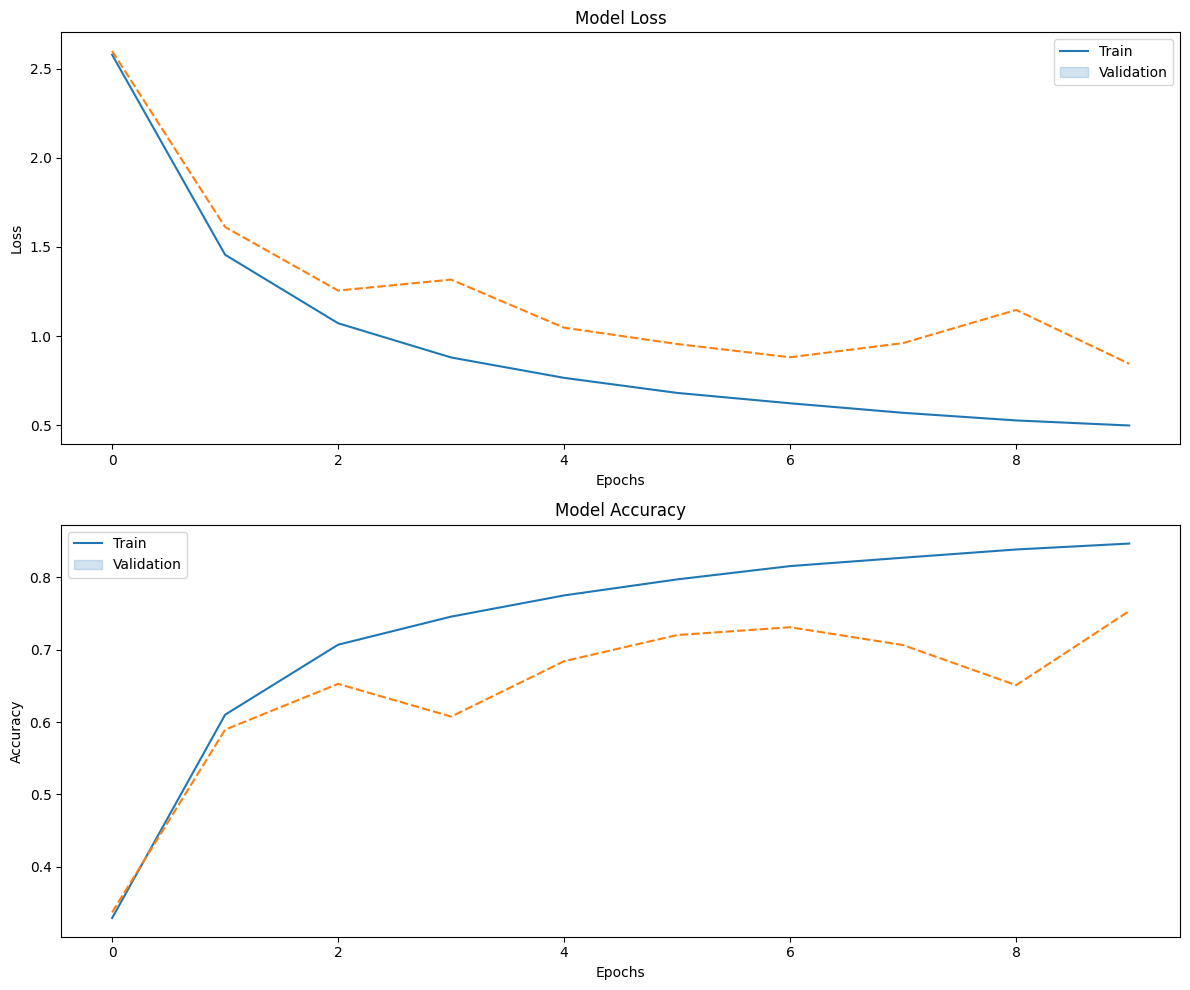

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,839,654 (335.08 MB)

 Trainable params: 272,678 (1.04 MB)

 Non-trainable params: 87,566,976 (334.04 MB)

None
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.2583 - loss: 2.9023 - val_accuracy: 0.4244 - val_loss: 2.2948
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.6445 - loss: 1.2612 - val_accuracy: 0.5130 - val_loss: 1.7583
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.7456 - loss: 0.8995 - val_accuracy: 0.6432 - val_loss: 1.1807
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.7894 - loss: 0.7199 - val_accuracy: 0.6492 - val_loss: 1.1566
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8198 - loss: 0.6170 - val_accuracy: 0.6106 - val_loss: 1.2411
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8338 - loss: 0.5473 - val_accuracy: 0.7149 - val_loss: 0.9625
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8499 - loss: 0.4948 - val_accuracy: 0.6823 - val_loss: 1.0298
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8596 - loss: 0.4489 - val

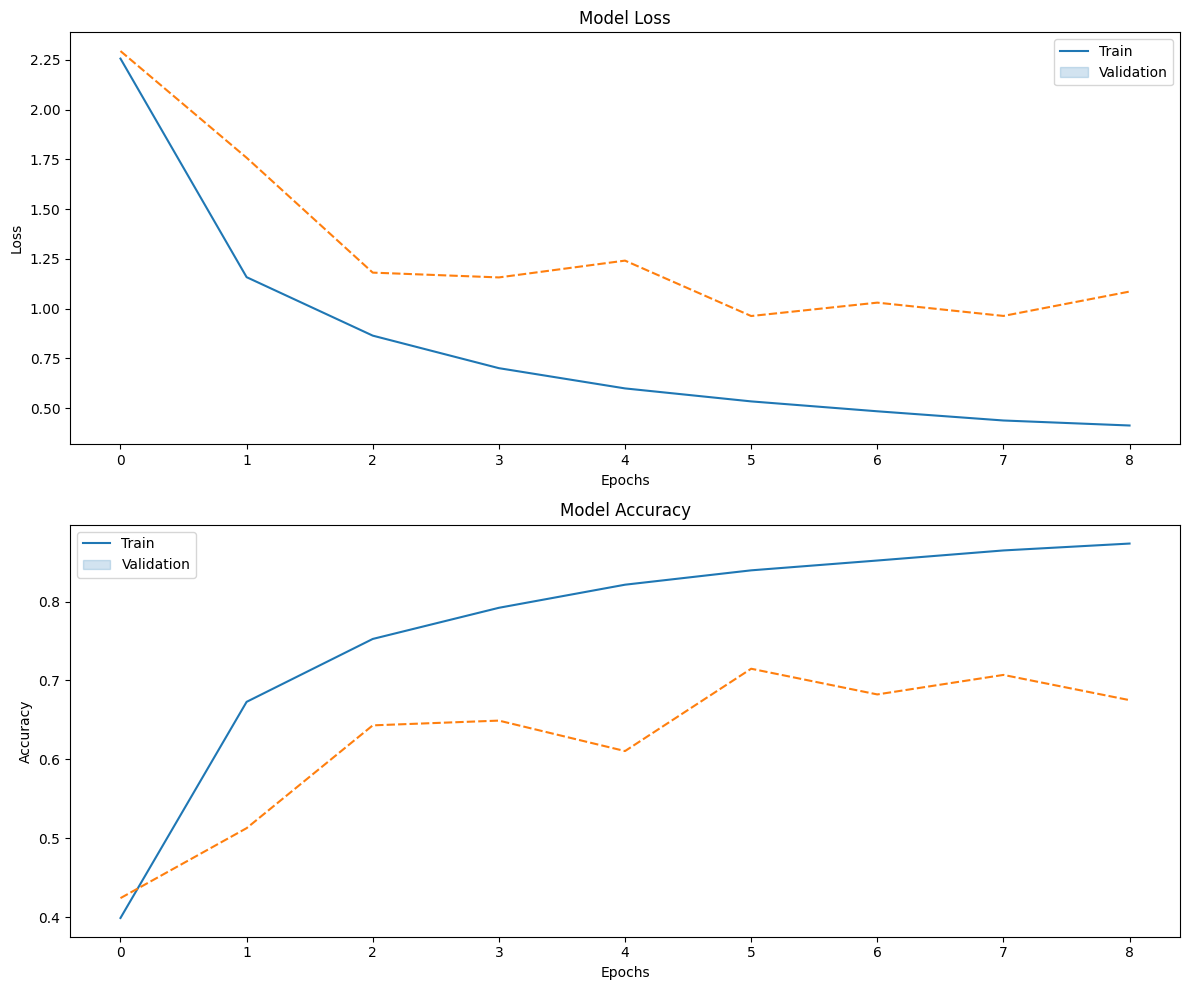

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,112,806 (336.12 MB)

 Trainable params: 545,318 (2.08 MB)

 Non-trainable params: 87,567,488 (334.04 MB)

None
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.3125 - loss: 2.6956 - val_accuracy: 0.3972 - val_loss: 2.1706
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.6957 - loss: 1.0627 - val_accuracy: 0.5401 - val_loss: 1.5246
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.7832 - loss: 0.7547 - val_accuracy: 0.6673 - val_loss: 1.1939
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8206 - loss: 0.6181 - val_accuracy: 0.6841 - val_loss: 1.0937
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8445 - loss: 0.5091 - val_accuracy: 0.6920 - val_loss: 1.0537
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8676 - loss: 0.4550 - val_accuracy: 0.6727 - val_loss: 1.0702
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8875 - loss: 0.3826 - val_accuracy: 0.6938 - val_loss: 1.0315
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.9004 - loss: 0.3513 - val

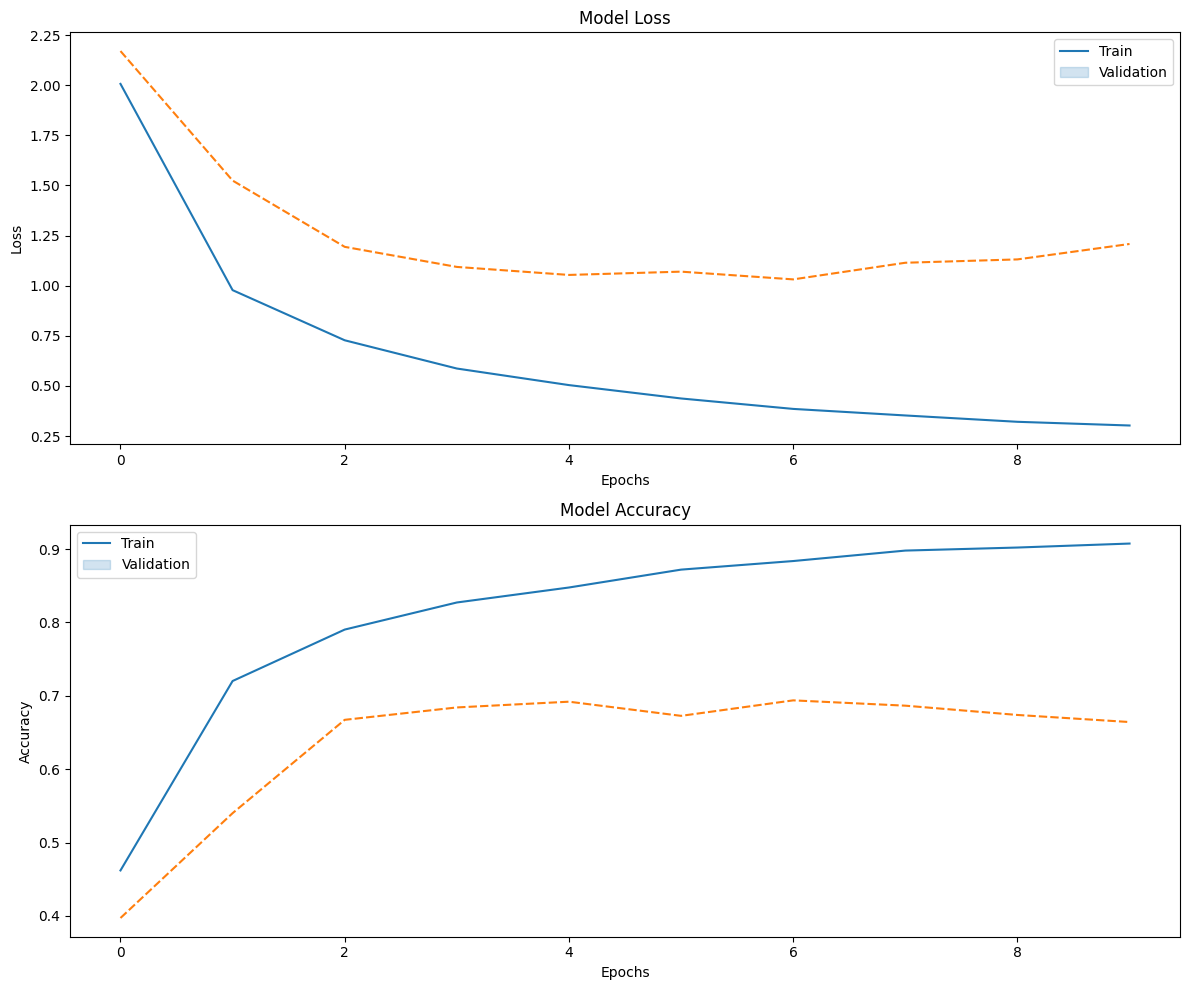

24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6630 - loss: 1.0555
Test Loss: 1.0406197309494019
Test Accuracy: 0.6756578683853149


In [10]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.ConvNeXtBase(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)

# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

### Confusion Matrix

  0%|          | 0/24 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 800ms/step


  4%|▍         | 1/24 [00:13<05:21, 14.00s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 797ms/step


  8%|▊         | 2/24 [00:15<02:29,  6.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step


 12%|█▎        | 3/24 [00:17<01:34,  4.51s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 806ms/step


 17%|█▋        | 4/24 [00:19<01:08,  3.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 21%|██        | 5/24 [00:20<00:53,  2.80s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 802ms/step


 25%|██▌       | 6/24 [00:22<00:43,  2.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step


 29%|██▉       | 7/24 [00:24<00:37,  2.19s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step


 33%|███▎      | 8/24 [00:26<00:32,  2.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step


 38%|███▊      | 9/24 [00:27<00:28,  1.93s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step


 42%|████▏     | 10/24 [00:29<00:25,  1.85s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 804ms/step


 46%|████▌     | 11/24 [00:31<00:23,  1.79s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 808ms/step


 50%|█████     | 12/24 [00:32<00:21,  1.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 804ms/step


 54%|█████▍    | 13/24 [00:34<00:19,  1.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 818ms/step


 58%|█████▊    | 14/24 [00:36<00:17,  1.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 808ms/step


 62%|██████▎   | 15/24 [00:37<00:15,  1.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step


 67%|██████▋   | 16/24 [00:39<00:13,  1.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step


 71%|███████   | 17/24 [00:41<00:11,  1.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step


 75%|███████▌  | 18/24 [00:42<00:10,  1.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 801ms/step


 79%|███████▉  | 19/24 [00:44<00:08,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 808ms/step


 83%|████████▎ | 20/24 [00:46<00:06,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step


 88%|████████▊ | 21/24 [00:47<00:05,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 801ms/step


 92%|█████████▏| 22/24 [00:49<00:03,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 806ms/step


 96%|█████████▌| 23/24 [00:51<00:01,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


100%|██████████| 24/24 [01:01<00:00,  2.57s/it]


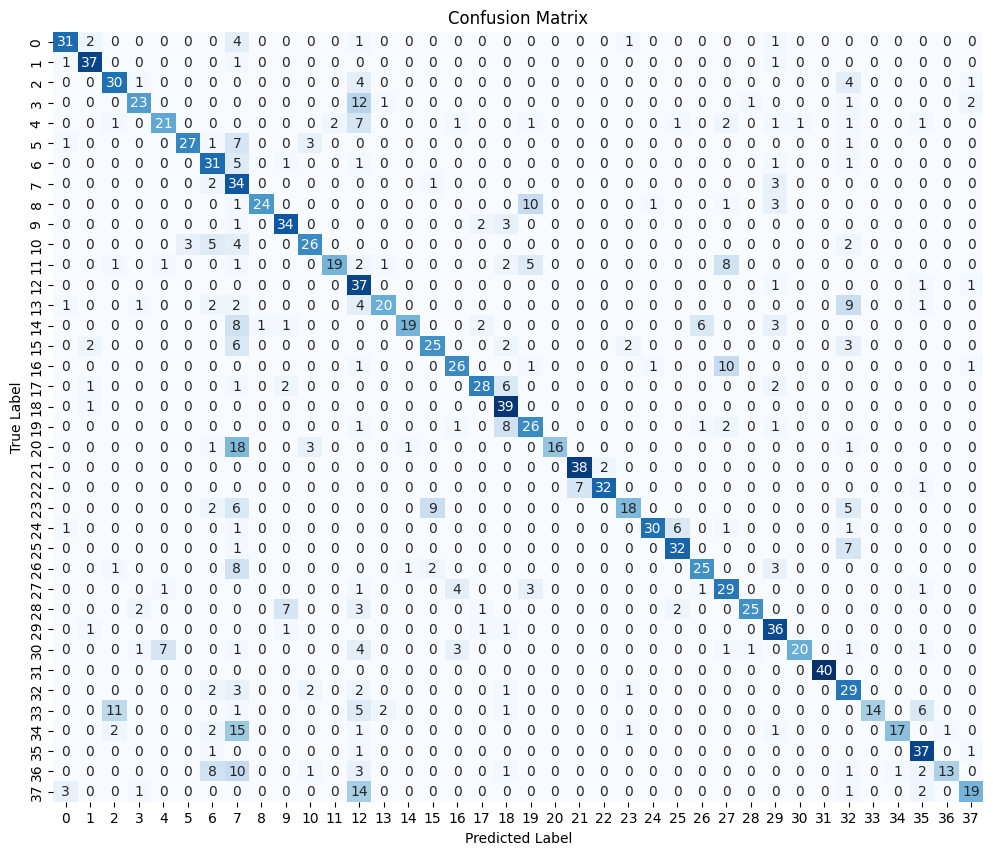

In [11]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)

## MobileNet FineTunning

Finally we will try to __finetune the entire MobileNet network__.

We expect this approach to perform better that the simple transfer learning, as we will be finetunning all the model parameters and not only the classification head.

Here, it's common to use a small learning rate.

__We will use the optimal model from the search above__, with a classification head of size `512`.

We first have to re-load the dataset with a smaller batch size, for example: `4`

In [3]:
train_dataset_path = "../../sign_datasets/bengali-sign-language-dataset/RESIZED_DATASET"
test_dataset_path = (
    "../../sign_datasets/bengali-sign-language-dataset/RESIZED_TESTING_DATA"
)

train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=4,
    validation_split=0.15,
    shuffle=True,
    seed=42,
    subset="both",
)

# The test dataset is under the test folder
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=4,
    shuffle=True,
)


def normalize_image(image, label):
    precomputed_mean = [0.6287722587585449, 0.6092960834503174, 0.5825445055961609]
    precomputed_std = [0.6499956250190735, 0.6389758586883545, 0.6195625066757202]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label


train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(
    f"Train size: {train_dataset.cardinality().numpy()}. Validation size will be: {val_dataset.cardinality().numpy()}"
)

# Set performance settings
# Prefetch one batch at a time
buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)


Found 11061 files belonging to 38 classes.
Using 9402 files for training.
Using 1659 files for validation.


I0000 00:00:1738775582.729614   20397 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2713 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 1520 files belonging to 38 classes.
Train size: 2351. Validation size will be: 415


In [7]:
HIDDEN_SIZE = 512

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # Metric to monitor
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)
# WE WANT to train the entire model
base_model.trainable = True


# Add custom layers on top of the base model
model = tf.keras.Sequential(
    [
        base_model,
        # This is added to reduce the number of parameters
        tf.keras.layers.GlobalAveragePooling2D(),
        # Add our custom hidden size
        tf.keras.layers.Dense(HIDDEN_SIZE, activation=None),
        # Use a batch normalization layer
        tf.keras.layers.BatchNormalization(),
        # Then the relu
        tf.keras.layers.Activation("relu"),
        # Dropout of 0.4
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

print(model.summary())

# Learning rate is set to 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping]
)

# plot two graphs, one for the train / val loss and one for the train / val accuracy
plot_history(history)


# Finally inference with the best model
results = model.evaluate(test_dataset)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,935,398 (11.20 MB)

 Trainable params: 2,900,262 (11.06 MB)

 Non-trainable params: 35,136 (137.25 KB)

None
Epoch 1/10
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 216s 70ms/step - accuracy: 0.3179 - loss: 2.6464 - val_accuracy: 0.8234 - val_loss: 0.5599
Epoch 2/10
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 139s 59ms/step - accuracy: 0.7889 - loss: 0.7562 - val_accuracy: 0.9162 - val_loss: 0.3032
Epoch 3/10
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 138s 59ms/step - accuracy: 0.8630 - loss: 0.4800 - val_accuracy: 0.9271 - val_loss: 0.2534
Epoch 4/10
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 139s 59ms/step - accuracy: 0.9023 - loss: 0.3657 - val_accuracy: 0.9210 - val_loss: 0.3182
Epoch 5/10
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - accuracy: 0.9240 - loss: 0.2978 - val_accuracy: 0.9325 - val_loss: 0.3033
Epoch 6/10
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 144s 61ms/step - accuracy: 0.9371 - loss: 0.2477 - val_accuracy: 0.9403 - val_loss: 0.3310
Epoch 7/10
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 145s 61ms/step - accuracy: 0.9403 - loss: 0.2248 - val_accuracy: 0.9542 - val_loss: 0.2475
Epoch 8/10
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 144s 61ms/step - accur

NameError: name 'plot_history' is not defined

### Confusion Matrix

In [ ]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = model.predict(x_batch, verbose=0)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)